# Write and read data in tfrecord format

This notebook shows how to read and write TFRecord files.

This is based on the examples [convert_to_records.py](https://github.com/tensorflow/tensorflow/blob/r1.12/tensorflow/examples/how_tos/reading_data/convert_to_records.py) and [fully_connected_reader.py](https://github.com/tensorflow/tensorflow/blob/r1.12/tensorflow/examples/how_tos/reading_data/fully_connected_reader.py) on the TensorFlow repository, and on [this post](http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/).

More info can be found on [TensorFlow's home page](https://www.tensorflow.org).

In [1]:
import matplotlib.pyplot as plt
import skimage.io as io
import tensorflow as tf

2022-10-12 09:46:04.474622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 09:46:04.760791: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-12 09:46:06.506156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/daint/UES/6.0.UP04/sandboxes/sarafael/software/cuDNN/8.1.0/lib:/opt/nvidia/hpc_sdk/Linux_x86_64/21.5/cuda/11.3/compat:/usr/local/cuda-11.3/compat:/opt/nvidia/hpc_sdk/Linux_x86_64/21.5/math_libs/11.3/lib64:/

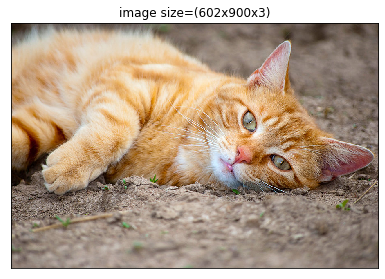

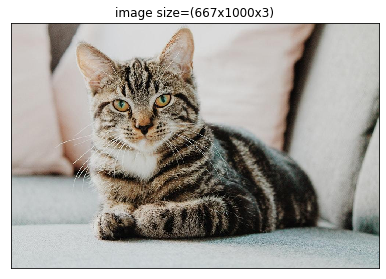

In [2]:
cat_array = io.imread('imgs/orange-cat.jpg')
io.imshow(cat_array)
io.imshow(cat_array)
plt.title('image size=(%sx%sx%s)' % cat_array.shape)
plt.xticks([])
plt.yticks([])
plt.show()

cat_array = io.imread('imgs/gray-cat.jpg')
io.imshow(cat_array)
io.imshow(cat_array)
plt.title('image size=(%sx%sx%s)' % cat_array.shape)
plt.xticks([])
plt.yticks([])
plt.show()

### 1. Define the types that can be written into the TFRecord file

In [3]:
def _bytes_feature(value):
    """Use this for string and byte types"""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Use this for bool, int32, uint32, int64 and uint64 types"""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(value):
    """Use this for float (float32) and double (float64) types"""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [4]:
_float_feature(4.5)

float_list {
  value: 4.5
}

In [5]:
_float_feature(4.5).SerializeToString()

b'\x12\x06\n\x04\x00\x00\x90@'

### 2. Write the images and labels to a TFRecord file
The steps to write on a TFRecord file are:
 1. Create (open) a TFRecord file.
 2. Loop over the data. The data will be written on the TFRecord file entry by entry.
 3. Create a feature dictionary (`tf.train.Features`) with the desired keys. The corresponding values will be the data represented as TensorFlow feature types (`_bytes_feature`, `_int64_feature`, ...).
 4. Create an example (`tf.train.Example`) from the feature dictionary which will be a record on the TFRecord file.
 5. Serialize the examples.
 6. Write on the file.
 7. Close the file.

In [6]:
filename_label = [('imgs/orange-cat.jpg', 'orange-cat'),
                  ('imgs/gray-cat.jpg', 'gray-cat')]

with tf.io.TFRecordWriter('cats.tfrecords') as writer:
    for img_path, label in filename_label:
        cat_array = io.imread(img_path)
        
        features_dict = {
            'image': _bytes_feature(cat_array.tobytes()),
            'label': _bytes_feature(label.encode(encoding='utf-8')),
            'height': _int64_feature(cat_array.shape[0]),
            'width': _int64_feature(cat_array.shape[1])
        }
                
        example = tf.train.Example(features=tf.train.Features(feature=features_dict))
        
        example_serialized = example.SerializeToString()

        writer.write(example_serialized)

***

### 3. Read from TFRecord file to Dataset object:

Steps:
 1. Load the TFRecord file to a dataset object with `the function tf.data.TFRecordDataset(tfrecords_filename)`.
 2. Create a function to parse the data from the TFRecord file into python or TensorFlow types and apply it through a map to the dataset.
 3. Do the normal operations to a dataset to define the input pipeline: maps, filters, batch, repeat, etc.
 
Parser function.
 1. Define a parser (`tf.io.parse_single_example`) from the serialized example and the features (keys) that will be loaded specifying their respective types (not all keys saved on the records need to be loaded).
 2. Return the the decoded data. 

In [7]:
def decode(serialized_example):
    """Parse an image and label from the given `serialized_example`."""

    example = tf.io.parse_single_example(
        serialized_example,
        features={
            'height': tf.io.FixedLenFeature((), tf.int64),
            'width':  tf.io.FixedLenFeature((), tf.int64),
            'image':  tf.io.FixedLenFeature((), tf.string),
            'label':  tf.io.FixedLenFeature((), tf.string),
        })

    width = example['width']
    height = example['height']
    label = example['label']
    image = tf.io.decode_raw(example['image'], tf.uint8)
    image = tf.reshape(image, (height, width, 3))

    return image, label

In [8]:
dataset = tf.data.TFRecordDataset('cats.tfrecords')
dataset = dataset.map(decode)
dataset = dataset.batch(1)

2022-10-12 09:50:07.749133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 09:50:08.473877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15391 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:02:00.0, compute capability: 6.0


orange-cat


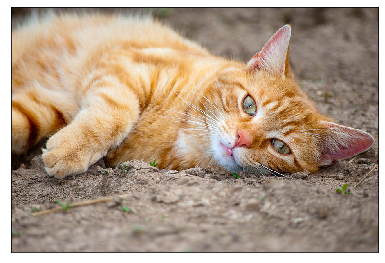

gray-cat


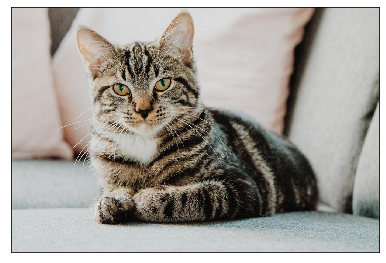

In [9]:
for image, label in dataset:
    io.imshow(image.numpy()[0])
    tf.print(label[0])
    plt.xticks([])
    plt.yticks([])
    plt.show()